In [1]:
from scipy.stats import pearsonr
from scipy import stats
from tqdm import tqdm
import mygene

def rank_push (input_adata, groupby, prefix, wkdir, s3dir, methods=['wilcoxon','t-test_overestim_var']):
    
    if len(methods) != 2:
        print('requires exactly 2 methods')
    else:
    
        rank_df = rank_genes(input_adata, 
                             methods=methods,
                             groupby=groupby)

        # inner join 2 methods 
        input_rank = rank_df
        joined_test = pd.merge(input_rank[input_rank['method'] == methods[0]]
                               .reset_index()
                               .rename(columns={'index':'{}_rank'.format(methods[0])})
                               .drop(columns='method', axis=1),
                             input_rank[input_rank['method'] == methods[1]]
                               .reset_index()
                               .rename(columns={'index':'{}_rank'.format(methods[1])})
                               .loc[:,['gene',groupby,'{}_rank'.format(methods[1])]],
                             'inner',
                             ['gene',groupby])

        # push to s3
        push_rank (rank_df, f'{prefix}_full', wkdir, s3dir)
        push_rank (joined_test, f'{prefix}_joined', wkdir, s3dir)
    
        return rank_df, joined_test
    
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

def symbol2field(genelist, field='summary',species='human'):
    # wrapper around mygene query
    # genelist = list of str gene symbols
    mg = mygene.MyGeneInfo()
    xli = genelist
    out = mg.querymany(xli, scopes='symbol', fields='summary', species=species)
    return out

def gene2plots(input_adata, gene, groupby, ordered_list):

    cats, casted_df = prepare_dataframe(input_adata, 
                                         gene, 
                                         groupby=groupby)

    melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)
    melt_df[f'{groupby}_cat'] = melt_df[groupby].astype(str).astype(CategoricalDtype(ordered_list, ordered=True))

    plotnine.options.figure_size = (4,4)
    print(ggplot(melt_df,aes(f'{groupby}_cat','value',color=f'{groupby}_cat'))
                  +theme_bw()
                  +theme(aspect_ratio=1,
                        axis_text_x=element_text(angle=90))
                  +geom_boxplot()
                  +stat_summary(aes(group=1), fun_y=np.median, geom='line',color='black')
                  +labs(y='log expression', x=''))

    # % of cells expressing CDKN2A
    cell_counts_df = casted_df.reset_index().groupby(groupby).describe().reset_index()
    gene_binary_df = casted_df[casted_df[gene] > 0].reset_index().groupby(groupby).describe().reset_index()

    df = pd.merge(gene_binary_df, cell_counts_df, 'left', groupby)
    df['prob'] = df[(f'{gene}_x','count')] /df[(f'{gene}_y','count')]
    df[f'{groupby}_cat'] = df[groupby].astype(str).astype(CategoricalDtype(ordered_list, ordered=True))
    print(ggplot(df.loc[:,[f'{groupby}_cat','prob']])
                +theme_bw()
          +theme(aspect_ratio=1,
                axis_text_x=element_text(angle=90))
          +geom_line(aes(f'{groupby}_cat','prob',group=1))
          +geom_point(aes(f'{groupby}_cat','prob',color=f'{groupby}_cat'))
          +labs(y='proportion of cells expressing', x=''))
    
def txn_noise(input_adata, groupby, pre_adata):
    # Calculates transcription noise as defined by https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6047899/
    # Updates adata obj inplace with new noise columns for each cell
    # Input: pre_adata (raw counts table), adata obj, groupby str that identifies categorical metadata field to define group reference
    # Output: extracted metadata table for plotting and post analysis

    groups=list(set(input_adata.obs[groupby].values))
    
    # process raw counts table to extract ERCC counts per cell
    ercc_df = (pre_adata
                   .reset_index()
                   .rename(columns = {'gene_name':'gene'}))
    ercc_names = [x for x in ercc_df['gene'] if 'ERCC-' in x]
    ercc_df_T = (ercc_df
                 .set_index('gene')
                 .T
                 .reset_index()
                 .rename(columns={'index':'cell'}))
    ercc_df_T.columns = (ercc_df_T
                         .columns
                         .get_level_values(0))

    # FOR GENES: preprocess adata obj to calculate group-wise mean expression
    means_df = (pd.merge((input_adata
                         .obs[groupby]
                         .reset_index()
                         .rename(columns={'index':'cell'})),
                        (ercc_df_T
                         .loc[:,[x for x in ercc_df_T.columns if not 'ERCC-' in x]]),
                        'left',
                        'cell')
                .groupby(groupby)
                .mean()
                .T)
    means_df.columns = [f'group_{x}' for x in means_df.columns]
    means_df = (means_df
                .reset_index()
                .rename(columns={'index':'gene'}))
    
    # FOR ERCC: preprocess adata obj to calculate group-wise mean expression 
    means_df_ercc = (pd.merge((input_adata
                              .obs[groupby]
                              .reset_index()
                              .rename(columns={'index':'cell'})),
                        (ercc_df_T
                         .loc[:,['cell']+[x for x in ercc_df_T.columns if 'ERCC-' in x]]),
                        'left',
                        'cell')
                     .groupby(groupby)
                     .mean()
                     .T)
    means_df_ercc.columns = [f'group_ercc_{x}' for x in means_df_ercc.columns]
    means_df_ercc = (means_df_ercc
                     .reset_index()
                     .rename(columns={'index':'gene'}))
    
    # Merge respective tables => ready for correlations
    merge_df = pd.merge(means_df, ercc_df,'left','gene')
    merge_df_ercc = pd.merge(means_df_ercc, ercc_df,'left','gene')

    # Groupby-matched Pearson correlations
    return_df = pd.DataFrame()
    for dataset in [merge_df, merge_df_ercc]:
        dat = (dataset.drop('gene',axis=1))
        refs = [x for x in dat.columns.tolist() if x.startswith('group')]
        i_list = [x for x in dat.columns.tolist() if not x.startswith('group')]

        for ref in refs:
            r_list = []
            for col in i_list:
                try:
                    df = dat[[ref,col]]
                    df = df.dropna()._get_numeric_data()
                    r, pval = pearsonr(df[ref], df[col])
                except:
                    r, pval = np.nan, np.nan

                r_list.append(r)
            out_df = pd.DataFrame({ref:r_list})
            return_df = pd.concat([return_df, out_df], axis=1)
            
    # add cell id
    return_df['cell'] = i_list
    return_df = pd.merge((input_adata
                          .obs[groupby]
                          .reset_index()
                          .drop(groupby,axis=1)
                          .rename(columns={'index':'cell'})),
                     return_df,
                     'left','cell')
    
    # update adata obj
    for x in groups:
        return_df[f'noise_{x}'] = (1-return_df[f'group_{x}'])/(1-return_df[f'group_ercc_{x}'])
        input_adata.obs[f'noise_{x}'] = [j if i == x else np.nan for i,j in zip(input_adata.obs[groupby].tolist(),
                                                                                return_df[f'noise_{x}'].tolist())]
    
    return input_adata
    
    

# Setup

In [2]:
# settings
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# download data from s3
# wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data'
# s3dir = 'daniel.le-work/MEL_project'
# for file in ['primary_mel_rawdata_181011.csv',
#              'primary_mel_metadata_181011.csv',
#              'DL20181106_bsc_metadata.csv',
#              'DL20181107_metadata_update.csv']:
#     ! aws s3 cp --quiet s3://{s3dir}/{file} {wkdir}/

# read annotation data
anno = pd.read_csv('s3://daniel.le-work/MEL_project/primary_mel_metadata_181011.csv', index_col=0)
anno = anno.loc[:, ['nGenes', 'nReads', 'well', 'plate', 'patient_id']]
anno = anno.rename(columns={'plate':'plate_barcode'})
anno['cell_name'] = ['{}_{}'.format(x,y) for x,y in zip(anno['well'], anno['plate_barcode'])]

# metadata update: 11-07-2018
plate_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20181107_metadata_update.csv')
plate_df = plate_df.loc[~plate_df['plate_barcode'].isnull(),:] # remove any row without plate barcode
plate_df = plate_df.loc[:, ['plate_barcode', 'patient_id', 'sample_color', 'age', 
                            'age_bin', 'sex','race', 'general_location', 'anatomical_location']]

# update metadata with merge
merged_anno = pd.merge(anno, plate_df, 'left', ['plate_barcode', 'patient_id'])

# append bsc metadata to anno
bsc = pd.read_csv('s3://daniel.le-work/MEL_project/DL20181106_bsc_metadata.csv')
merged_anno = pd.merge(merged_anno,bsc,'left',['well','plate_barcode'])
merged_anno = merged_anno.set_index('cell_name')

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190104_counts_wERCC.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))

# markers
markers = ['PMEL','KRT1','KRT5','KRT10','TYR','MITF']

scanpy version: 1.3.3


# Ingest data protocol
- Raw data and annotation CSV provided by Ashley Maynard

In [3]:
raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
raw_adata.var['ercc'] = np.array([True if 'ERCC' in x else False for x in raw_adata.var_names.tolist()])
sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo','ercc'], inplace=True)
anno_dict = {'age':'age',
             'age_bin':'age_bin',
             'plate':'plate_barcode',
             'general_location':'general_location',
             'anatomical_location':'anatomical_location',
             'race':'race',
             'sex':'sex',
             'color':'sample_color',
             'patient':'patient_id',
             'bsc': 'bsc_a'}
append_anno(raw_adata, merged_anno, anno_dict)
append_markers(raw_adata, gene_markers=markers)
technical_filters(raw_adata)
raw_adata = remove_ercc(raw_adata) 
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
	Cells: 4356, Genes: 26577
Append annotations...
	Cells: 4356, Genes: 26577
Append marker gene expresssion...
Remove low-quality cells/genes...
	Initial:
	Cells: 4356, Genes: 26577
	Result:
	Cells: 4356, Genes: 23280
Remove ERCC genes...
Filtered genes: 85
	Cells: 4356, Genes: 23195


# All-cells analysis

Process expression data...
	Initial:
	Cells: 4356, Genes: 23195
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13053
	Result:
	Cells: 4356, Genes: 10142
Principle component analysis...


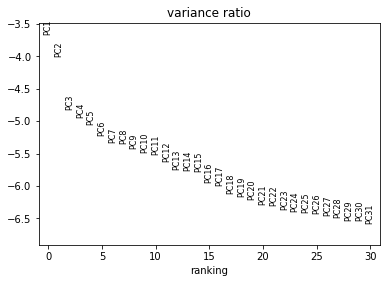

principle_components(num_pcs): 16
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


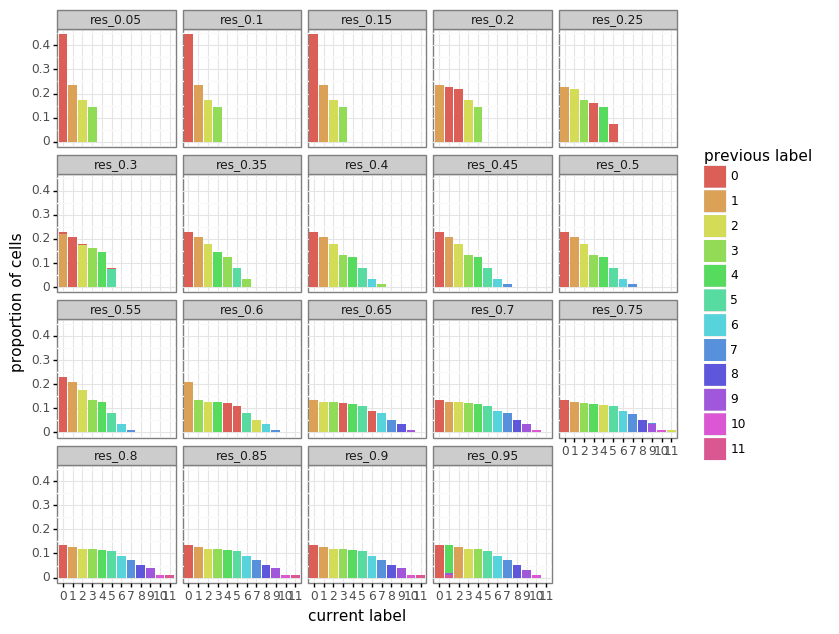

<ggplot: (8766870615830)>


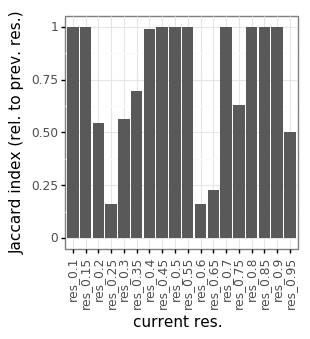

<ggplot: (-9223363269982750797)>
resolution(res): 0.25


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


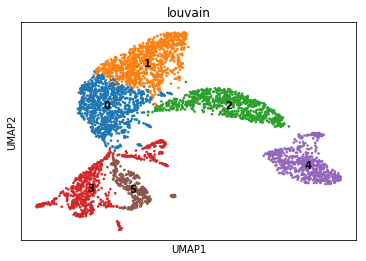

In [4]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=16)
umap_adata(full_adata, res=0.25)

# Classify MEL vs KRT
- Manual classification based on marker gene expression

In [5]:
# classify in raw adata
input_adata = full_adata

MEL_int = [0,1,2,4]
KRT_int = [x for x in range(len(input_adata.obs['louvain'].cat.categories)) if x not in MEL_int]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}
    
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_1')

# MEL only re-cluster

key = class_1, value = MEL, matched = 3331
	Cells: 3331, Genes: 23195
Process expression data...
	Initial:
	Cells: 3331, Genes: 23195
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13206
	Result:
	Cells: 3331, Genes: 9989
Principle component analysis...


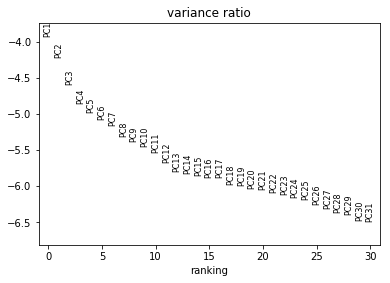

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


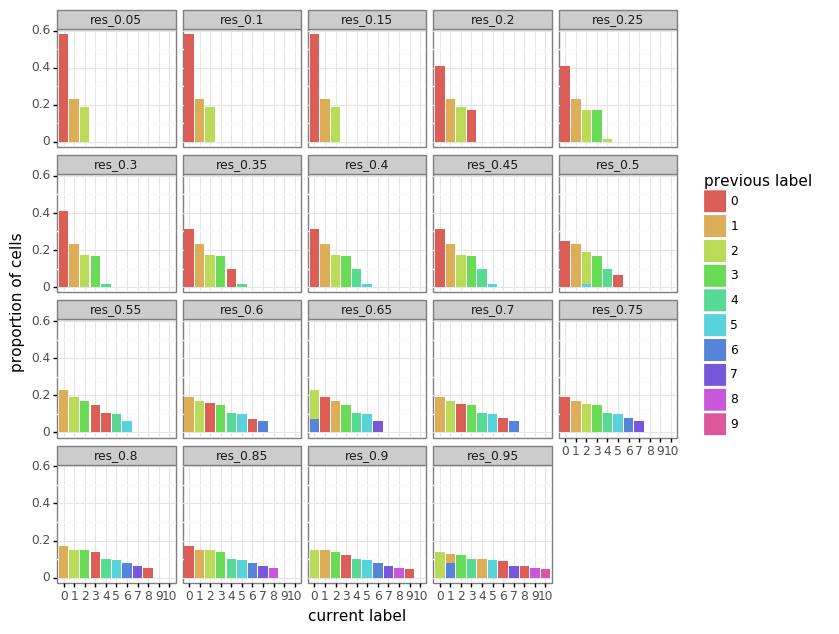

<ggplot: (8766875197020)>


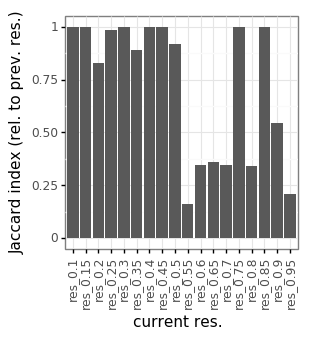

<ggplot: (-9223363269984027220)>
resolution(res): 0.15


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


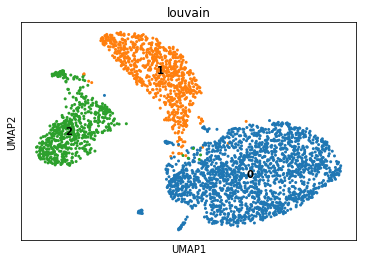

In [6]:
# MEL only

feature_dict = {'class_1':['MEL']}
adata_subset1 = subset_adata_v3(raw_adata,feature_dict)
adata_subset1 = process_adata(adata_subset1)
pca_adata(adata_subset1, num_pcs=30)
umap_adata(adata_subset1, res=0.15)

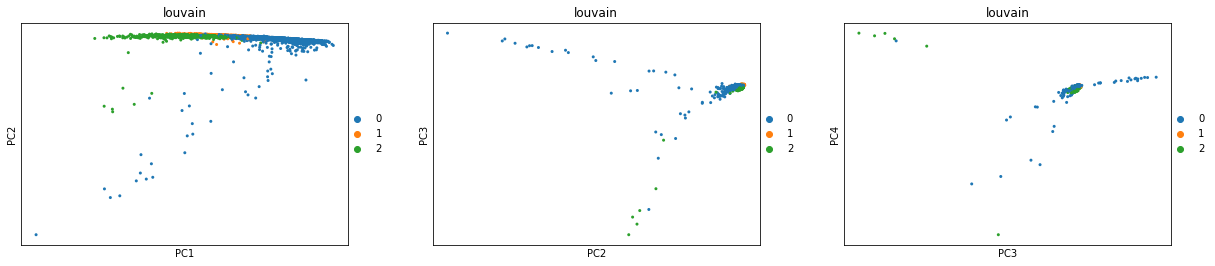

Filtered cells:  316


... storing 'outliers' as categorical


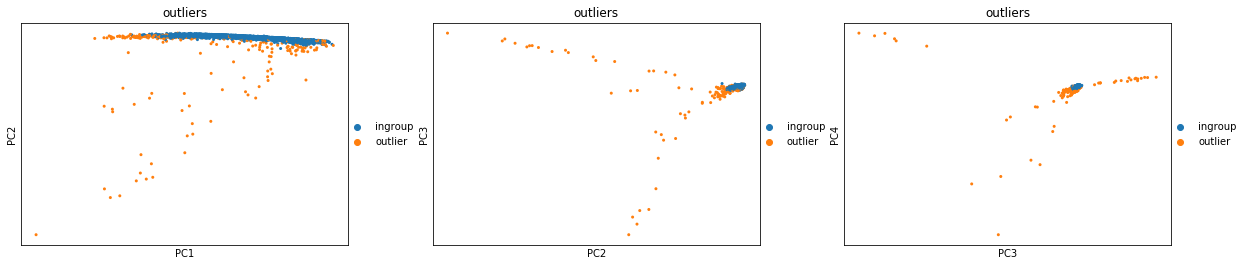

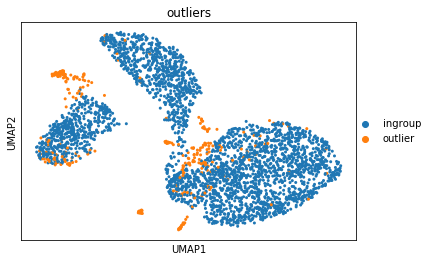

... storing 'outliers' as categorical


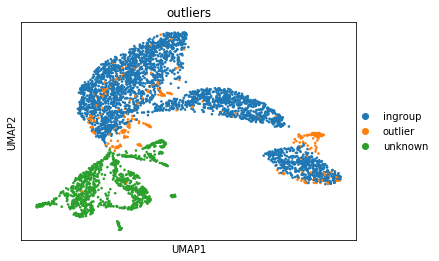

In [7]:
# initial PC coordinates
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(adata_subset1.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
#     print(len(set(omit_names)))
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=4

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]
    filtered = df[bool_idx]
#     print('Filtered cells: ', len(df)-len(filtered))
    
    omit_names = omit_names + adata_subset1.obs[[not x for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))
test = raw_adata[[x for x in raw_adata.obs.index if x not in set(omit_names)]]

# check where the outliers lie in original projection
input_adata = adata_subset1
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# outliers on all-cells projection
input_adata = adata_subset1

type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')

sc.pl.umap(full_adata, color=['outliers'])

key = class_2, value = in, matched = 3015
	Cells: 3015, Genes: 23195
Process expression data...
	Initial:
	Cells: 3015, Genes: 23195
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 12877
	Result:
	Cells: 3015, Genes: 10318
Principle component analysis...


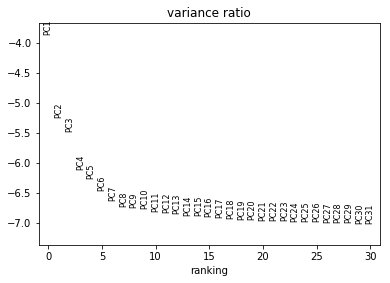

principle_components(num_pcs): 7
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


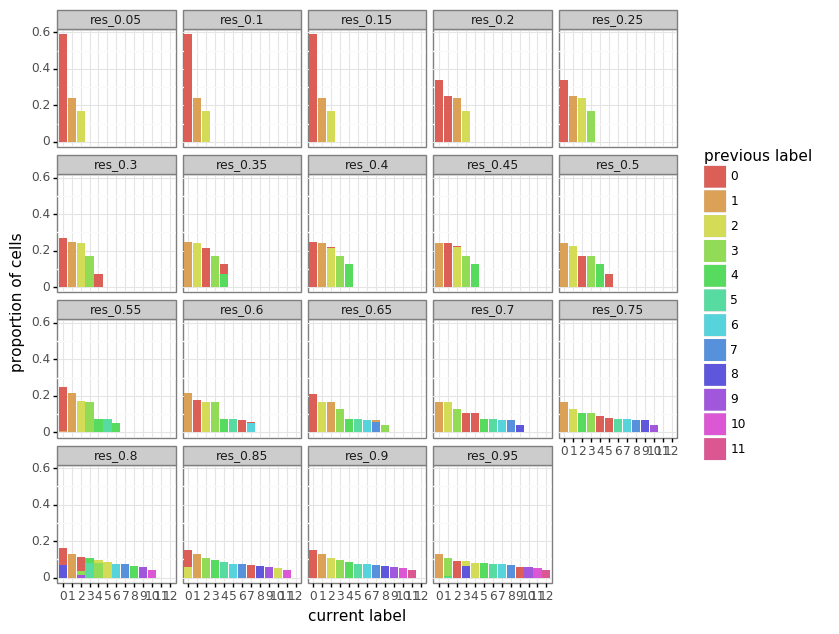

<ggplot: (-9223363269982758754)>


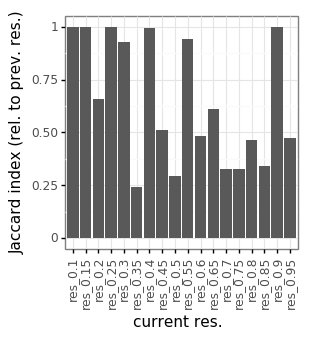

<ggplot: (8766871545513)>
resolution(res): 0.1


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_2' as categorical


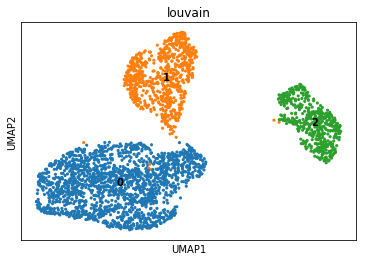

In [8]:
# classify in raw adata
input_adata = adata_subset1

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
adata_subset2 = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(adata_subset2)
pca_adata(adata_subset2, num_pcs=7)
umap_adata(adata_subset2, res=0.1)

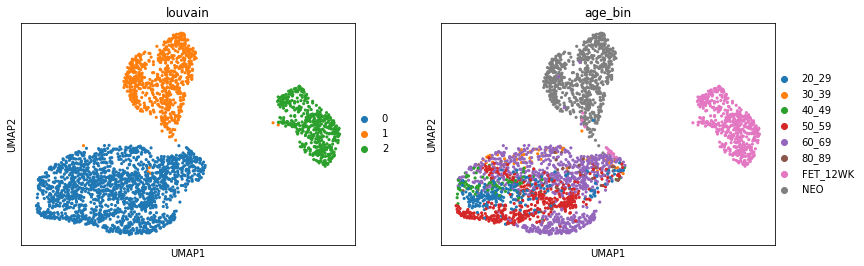

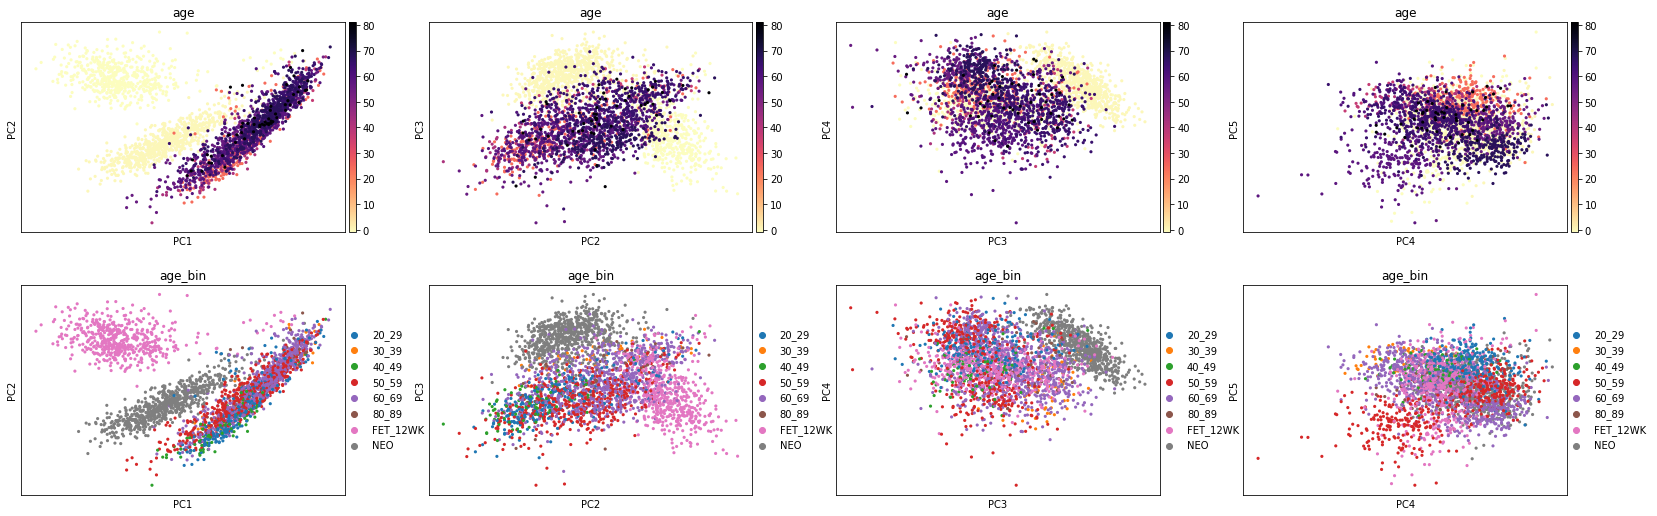

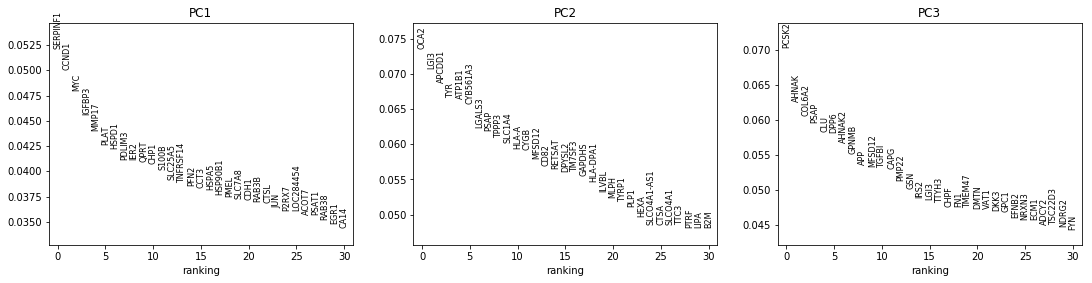

In [9]:
sc.pl.umap(adata_subset2, color=['louvain','age_bin'], cmap='magma_r')
sc.pl.pca(adata_subset2, components=['1,2','2,3','3,4','4,5'], color=['age','age_bin'], cmap='magma_r')
sc.pl.pca_loadings(adata_subset2)

# Transcriptional noise

In [14]:
# compute txn noise
input_adata = adata_subset2
groupby='patient'
input_adata = txn_noise(input_adata, groupby, pre_adata)


In [15]:
# condense adult group
reclass_dict = {'FET_12WK':'FET_12WK',
                 'NEO':'NEO',
                 '20_29':'20_49',
                 '30_39':'20_49',
                 '40_49':'20_49',
                 '50_59':'50_89',
                 '60_69':'50_89',
                 '80_89':'50_89'}
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_bin']
                                  .map(reclass_dict))
ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_group']
                                  .astype(str)
                                  .astype(CategoricalDtype(ordered_groups, ordered=True)))


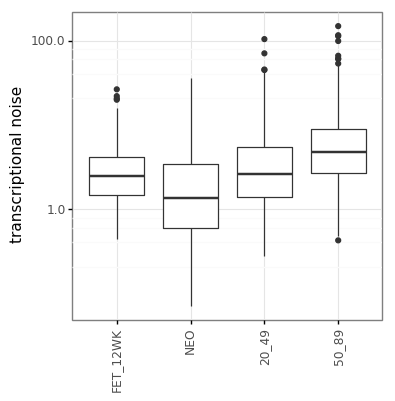

<ggplot: (-9223363297944465485)>
H-test:  586.0103665229162 p-value 1.0866699746414274e-126
U-test (50_89 vs NEO):  205073.0 p-value 3.3621483341732287e-106


In [16]:
# process for plotting
groupby = 'age_group'
plot_df = (input_adata
           .obs
           .loc[:, [f'{x}' for x in input_adata.obs.columns if x.startswith('noise')] + [groupby]])
plot_df = pd.melt(plot_df, id_vars=groupby)

# plot
plotnine.options.figure_size=(4,4)
print(ggplot(plot_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90))
         +geom_boxplot(aes(groupby,'value'))
         +labs(y='transcriptional noise',x='')
         +scale_y_log10())


# Compute the Kruskal-Wallis H-test for independent samples
groups_dict = {}
for group in list(set(plot_df[groupby])):
    group_vec = plot_df[plot_df[groupby] == group]['value'].dropna().tolist()
    groups_dict[group] = group_vec

eval_list = [f'groups_dict["{i}"]' for i in groups_dict.keys()]
eval_subcmd = ','.join(eval_list)
eval_cmd = f'stats.kruskal({eval_subcmd})'
hstat, pval = eval(eval_cmd)
print('H-test: ', hstat, 'p-value', pval)

# Compute Mann-Whitney U-test for pairwise rank test
group1 = '50_89'
group2 = 'NEO'
ustat, pval = stats.mannwhitneyu(groups_dict[group1],groups_dict[group2])
print(f'U-test ({group1} vs {group2}): ', ustat, 'p-value', pval)

In [494]:


# transcriptional noise for KRTs?
adata_subset2


AnnData object with n_obs × n_vars = 3015 × 10318 
    obs: 'total_features_by_counts', 'log1p_total_features_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_ercc', 'log1p_total_counts_ercc', 'pct_counts_ercc', 'age', 'age_bin', 'plate', 'general_location', 'anatomical_location', 'race', 'sex', 'color', 'patient', 'bsc', 'PMEL', 'KRT1', 'KRT5', 'KRT10', 'TYR', 'MITF', 'n_genes', 'n_counts', 'class_1', 'class_2', 'louvain', 'noise_FS043_LM', 'noise_A1014L', 'noise_A1020LM', 'noise_A1015LM', 'noise_A1021M', 'noise_A1022M', 'noise_A1025L', 'noise_A1017LM', 'noise_A1012M', 'noise_FS030_LM', 'noise_12WKM01', 'noise_A1016LM', 'noise_A1011L', 'age_group'
    var: 'ribo', 'ercc', 'mean_counts', 'log1p_mean_counts', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts', 'lo

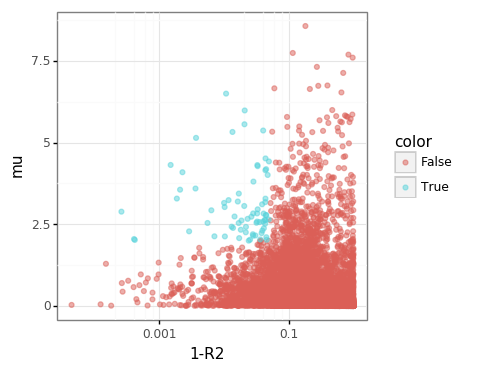

<ggplot: (-9223363294646321271)>


,gene,R,pval,mu,R2,1-R2,color
3580,HNRNPDL,0.999869,0.000131,2.887537,0.999738,0.000262,True
6557,PAFAH1B3,0.999795,0.000205,2.049514,0.999590,0.000410,True
7417,RABL6,0.999789,0.000211,2.023288,0.999579,0.000421,True
1169,CALD1,0.999247,0.000753,4.315457,0.998494,0.001506,True
4182,KMT2E,0.999060,0.000940,3.288050,0.998122,0.001878,True
1942,CYP27A1,0.998946,0.001054,3.559278,0.997894,0.002106,True
6984,PLOD3,0.998854,0.001146,4.093159,0.997708,0.002292,True
1193,CAPN2,0.998546,0.001454,2.285526,0.997095,0.002905,True
6989,PLTP,0.998176,0.001824,3.594940,0.996355,0.003645,True
9681,VAT1,0.998140,0.001860,5.143465,0.996284,0.003716,True


In [420]:
# refactor to include all genes?
# must stick with normalized expression?
#
#
#

ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
groupby='age_group'

cat, df = prepare_dataframe(adata_subset2, 
                  var_names=adata_subset2.var_names,
                  groupby=groupby)

# coefficient of variation vs age bin
gene_std = df.groupby(groupby).std()
gene_mean = df.groupby(groupby).mean()
gene_coef = gene_std/gene_mean
gene_coef = gene_coef.reset_index()
gene_coef[groupby] = (gene_coef[groupby]
                      .astype(str)
                      .astype(CategoricalDtype(ordered_groups, ordered=True)))
gene_coef = (gene_coef
             .set_index(groupby)
             .sort_index())

r_list=[]
p_list=[]
mu_list=[]
for x in gene_coef.columns:
    r,p = pearsonr([x for x in range(gene_coef.shape[0])], 
                   gene_coef.loc[:, x])
    r_list.append(r)
    p_list.append(p)
    mu_list.append(df.loc[:,x].mean())
coef_df = pd.DataFrame({'gene':gene_coef.columns,
                         'R':r_list,
                         'pval':p_list,
                       'mu':mu_list})
coef_df['R2'] = coef_df['R']**2
coef_df['1-R2'] = 1-coef_df['R2']
condition_vec = [((x < 0.05) and (y > 2)) for x,y in zip(coef_df['1-R2'], coef_df.mu)] 
coef_df['color'] = condition_vec
coef_df = coef_df.sort_values('pval', ascending=True)
coef_df = coef_df.dropna()

# plot and print 
print(ggplot(coef_df)
      +theme_bw()
      +geom_point(aes('1-R2','mu', color = 'color'), alpha = 0.5)
      +scale_x_log10())

coef_df[coef_df.color == True]

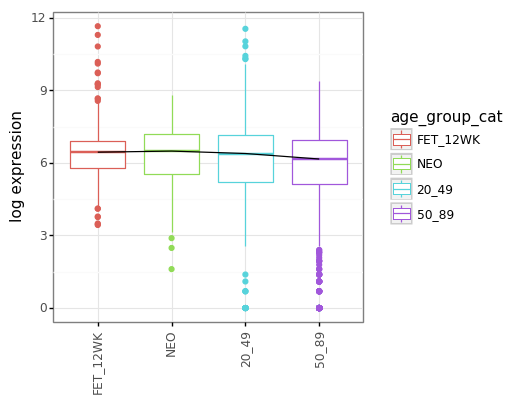

<ggplot: (8738906350754)>


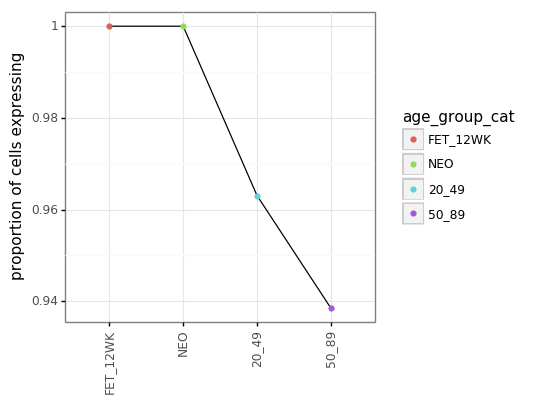

<ggplot: (8738715771077)>


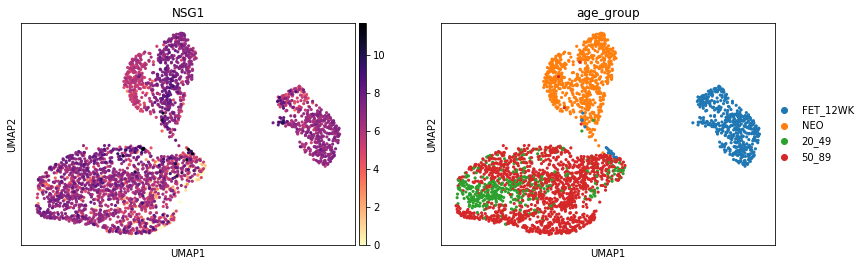

querying 1-1...done.
Finished.
0:  NSG1 
 N/A
no txn noise data


In [37]:
gene = 'NSG1'
input_adata = adata_subset2
groupby='age_group'
ordered_list = ordered_groups

gene2plots(input_adata, gene, groupby, ordered_list)
sc.pl.umap(input_adata, color=[gene, 'age_group'], cmap='magma_r')
out = symbol2field(gene)
[print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

try: 
    print(gene_coef.loc[:,gene])
except:
    print('no txn noise data')


In [421]:
gene = coef_df[coef_df.color == True].gene
out = symbol2field(gene)
[print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

querying 1-72...done.
Finished.
1 input query terms found no hit:
	['NOV']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0:  HNRNPDL 
 This gene belongs to the subfamily of ubiquitously expressed heterogeneous nuclear ribonucleoproteins (hnRNPs). The hnRNPs are RNA binding proteins and they complex with heterogeneous nuclear RNA (hnRNA). These proteins are associated with pre-mRNAs in the nucleus and appear to influence pre-mRNA processing and other aspects of mRNA metabolism and transport. While all of the hnRNPs are present in the nucleus, some seem to shuttle between the nucleus and the cytoplasm. The hnRNP proteins have distinct nucleic acid binding properties. The protein encoded by this gene has two RRM domains that bind to RNAs. Three alternatively spliced transcript variants have been described for this gene. One of the variants is probably not translated because the transcript is a candidate for nonsense-mediated mRNA decay. The protein is

 The protein encoded by this gene is a member of the protein tyrosine phosphatase (PTP) family. PTPs are known to be signaling molecules that regulate a variety of cellular processes including cell growth, differentiation, mitotic cycle, and oncogenic transformation. This PTP contains an extracellular domain, a single transmembrane segment and two tandem intracytoplasmic catalytic domains, and thus represents a receptor-type PTP. This PTP has been shown to dephosphorylate and activate Src family tyrosine kinases, and is implicated in the regulation of integrin signaling, cell adhesion and proliferation. Three alternatively spliced variants of this gene, which encode two distinct isoforms, have been reported. [provided by RefSeq, Jul 2008].
26:  DCAF7 
 This gene encodes a protein with multiple WD40 repeats which facilitate protein-protein interactions and thereby enable the assembly of multiprotein complexes. This protein has been shown to function as a scaffold protein for protein com

 The protein encoded by this gene is a member of the transmembrane 4 superfamily, also known as the tetraspanin family. Most of these members are cell-surface proteins that are characterized by the presence of four hydrophobic domains. The proteins mediate signal transduction events that play a role in the regulation of cell development, activation, growth and motility. This encoded protein is a cell surface glycoprotein that is known to complex with integrins. This protein appears to promote muscle cell fusion and support myotube maintenance. Also it may be involved in signal transduction. This gene is localized in the tumor-suppressor gene region and thus it is a candidate gene for malignancies. Two transcript variants encoding different isoforms have been found for this gene. [provided by RefSeq, Jul 2014].
60:  NOV 
 N/A
61:  ZFAND5 
 N/A
62:  P2RX7 
 The product of this gene belongs to the family of purinoceptors for ATP. This receptor functions as a ligand-gated ion channel and i

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [394]:
reclass_dict = {'FET_12WK':'FET_12WK',
                 'NEO':'NEO',
                 '20_29':'20_49',
                 '30_39':'20_49',
                 '40_49':'20_49',
                 '50_59':'50_89',
                 '60_69':'50_89',
                 '80_89':'50_89'}
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_bin']
                                  .map(reclass_dict))
ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_group']
                                  .astype(str)
                                  .astype(CategoricalDtype(ordered_groups, ordered=True)))


['DDX23', 'EFTUD2', 'HNRNPM', 'PDCD7', 'PRPF8', 'SF3B2', 'SF3B3', 'SLU7', 'SNRNP200', 'SNRNP25', 'SNRNP40', 'SNRNP48', 'SNRPB']


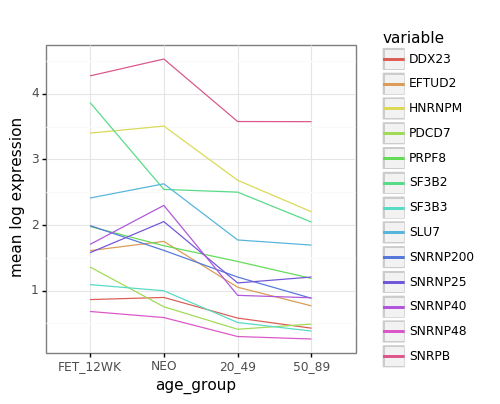

<ggplot: (8742166492957)>


In [405]:
# spliceosome gene set, ref: http://software.broadinstitute.org/gsea/msigdb/cards/SPLICEOSOME.html
input_adata = adata_subset2

geneset = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/spliceosome_genes.txt',
           delimiter = '\t', usecols=[1], header=None)
geneset.columns = ['gene']
geneset = [x for x in geneset.gene if x in input_adata.var_names]
print(geneset)

ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
groupby='age_group'

cats, casted_df = prepare_dataframe(input_adata, 
                                         geneset, 
                                         groupby=groupby)

melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)
melt_df[f'{groupby}_cat'] = melt_df[groupby].astype(str).astype(CategoricalDtype(ordered_groups, ordered=True))

plot_df = pd.DataFrame(melt_df.groupby(['age_group_cat','variable']).mean().to_records())
plot_df['age_group_cat'] = plot_df['age_group_cat'].astype(str).astype(CategoricalDtype(ordered_groups,ordered=True))

print(ggplot(plot_df)
     +theme_bw()
     +geom_line(aes('age_group_cat','value', group='variable', color='variable'))
     +labs(x='age_group',y='mean log expression'))


# DE genes: outliers vs rest

In [11]:
input_adata = adata_subset1
groupby='outliers'
prefix='AllMel_aging_outliers'

full_df, joint_df = rank_push (input_adata, groupby, prefix, wkdir, s3dir)

wilcoxon
ingroup    outlier
     TYR        TK1
    CD59       IER3
    QPCT       PRC1
    PLP1  LOC284454
    PSAP      DUSP1
CYB561A3        HN1
   CAPN3   KIAA0101
    MITF       IDH2
   TYRP1      TUBG1
   GPNMB       CKS2


100%|██████████| 2/2 [00:09<00:00,  4.70s/it]


t-test_overestim_var
ingroup   outlier
   TYR       TK1
  CD59  KIAA0101
  QPCT     MKI67
 TYRP1      PRC1
  MITF     MYBL2
 CAPN3       PBK
 GPNMB    PKMYT1
 GPM6B     BIRC5
  PSAP    NUSAP1
  PLP1     ASF1B


100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/GeneRank_AllMel_aging_outliers_full.csv
https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/GeneRank_AllMel_aging_outliers_joined.csv


# DE genes: age bin vs rest

In [12]:
input_adata = adata_subset2
groupby='age_bin'
prefix='AllMel_aging'

full_df, joint_df = rank_push (input_adata, groupby, prefix, wkdir, s3dir)


wilcoxon
20_29    30_39   40_49    50_59   60_69  80_89   FET_12WK       NEO
       ROPN1  S100A10    CYGB    HLA-C  S100A6  IFI27      LYPD1  SERPINF1
    CYB561A3   LGALS1  FRG2DP    HLA-B    APOD   CES1        FOS   C3orf79
      ATP1B1    SERF2    CAPG    TGFBI   FXYD3  HLA-H  LOC284454       MAL
       TYRP1     EMP3  AHNAK2   CRABP1     CLU   GNAL       PLAT      ETV5
        DKK3   S100A6   PSRC1  TSC22D3  CRABP1  OR7A5    MIR3654    ZNF749
      MFSD12    IFI27   MXRA7    HLA-A    MT2A  HERC2       PXDN     S100B
LOC101930452     APOD  TMEM47    NDRG2   NDRG2   PER1      SOX11     RAB38
        SELM    SRP14    TFF3    FADS2  LGALS1   APOD       FOSB    ZC3H13
        LGI3     CD63  ATP1B1   MFSD12   RAMP1   KLF4    EIF5AL1     PRKD3
       PCSK2    RPS28  SCUBE2    DDIT4   GPM6B   MT1E       IER2    RASSF3


100%|██████████| 8/8 [01:20<00:00, 11.11s/it]


t-test_overestim_var
20_29    30_39   40_49    50_59   60_69  80_89   FET_12WK       NEO
       ROPN1    IFI27    CYGB    HLA-C  S100A6  IFI27      LYPD1  SERPINF1
      ATP1B1   LGALS1    CAPG    TGFBI   FXYD3  HLA-H        FOS   C3orf79
        DKK3  S100A10  FRG2DP    HLA-B     CLU   CES1  LOC284454       MAL
        SELM   S100A6  AHNAK2   CRABP1    APOD  OR7A5       PLAT     S100B
LOC101930452   CRABP1   MXRA7  TSC22D3  CRABP1   GNAL       PXDN    ZNF749
         CLU     EMP3  TMEM47    NDRG2   NDRG2  HERC2    MIR3654      ETV5
    CYB561A3    SERF2   PSRC1    HLA-A   RAMP1   MT1E       IER2     RAB38
      CRABP1     CD63    CTSK    FADS2    SELM   APOD      RAB3B    ZC3H13
       TYRP1    GNG11  ATP1B1     RGCC    EMX2  HLA-C      SOX11     PRKD3
        CAPG    RPS27    MPP4      CKB    MT2A   PER1       FOSB      GPX1


100%|██████████| 8/8 [01:49<00:00, 12.67s/it]


https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/GeneRank_AllMel_aging_full.csv
https://s3-us-west-2.amazonaws.com/daniel.le-work/MEL_project/GeneRank_AllMel_aging_joined.csv


# Gene and age correlation

          gene         R           pval        R2
7993  SERPINF1 -0.883770  7.542922e-311  0.781050
1785    CRABP1  0.702246  7.542922e-311  0.493149
1651       CLU  0.694406  7.542922e-311  0.482200
1342     CCND1 -0.667657  7.542922e-311  0.445766
6010       MYC -0.649814  7.542922e-311  0.422258
3752    IGFBP3 -0.645882  7.542922e-311  0.417164
7812    S100A6  0.642069  7.542922e-311  0.412253
3543     HLA-B  0.635037  7.542922e-311  0.403272
3544     HLA-C  0.623593  7.542922e-311  0.388868
478       APOD  0.613144  7.542922e-311  0.375945
723        B2M  0.594929  3.653479e-288  0.353941
7817     S100B -0.591118  1.342046e-283  0.349420
7375      QPRT -0.572657  2.501788e-262  0.327936
3672     HSPD1 -0.567901  4.581546e-257  0.322512
6137     NDRG2  0.565775  9.689566e-255  0.320102
2984     FXYD3  0.544766  1.195803e-232  0.296770
1559      CHP1 -0.542473  2.485271e-230  0.294277
8175   SLC25A5 -0.537908  9.018250e-226  0.289345
3720      IER2 -0.531286  2.795472e-219  0.282265


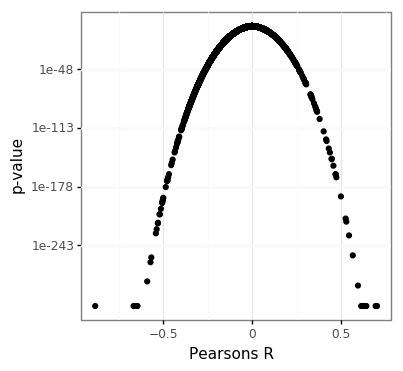

<ggplot: (8753520285865)>
Top negatively correlated genes


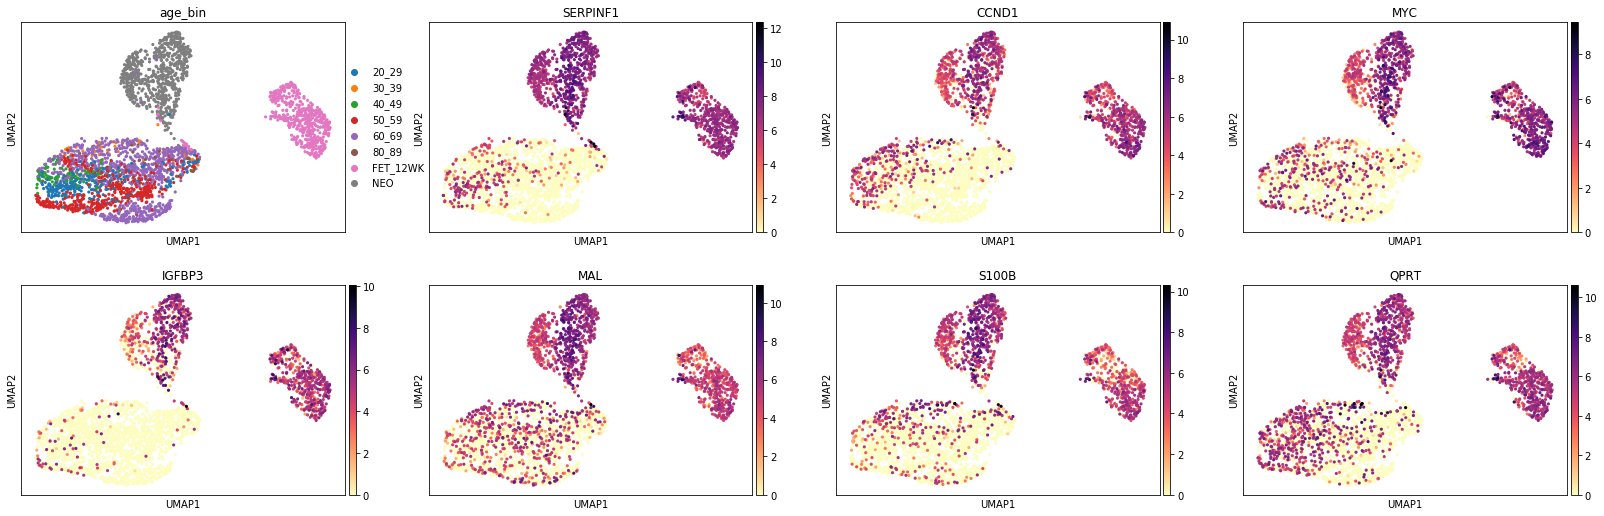

Top positively correlated genes


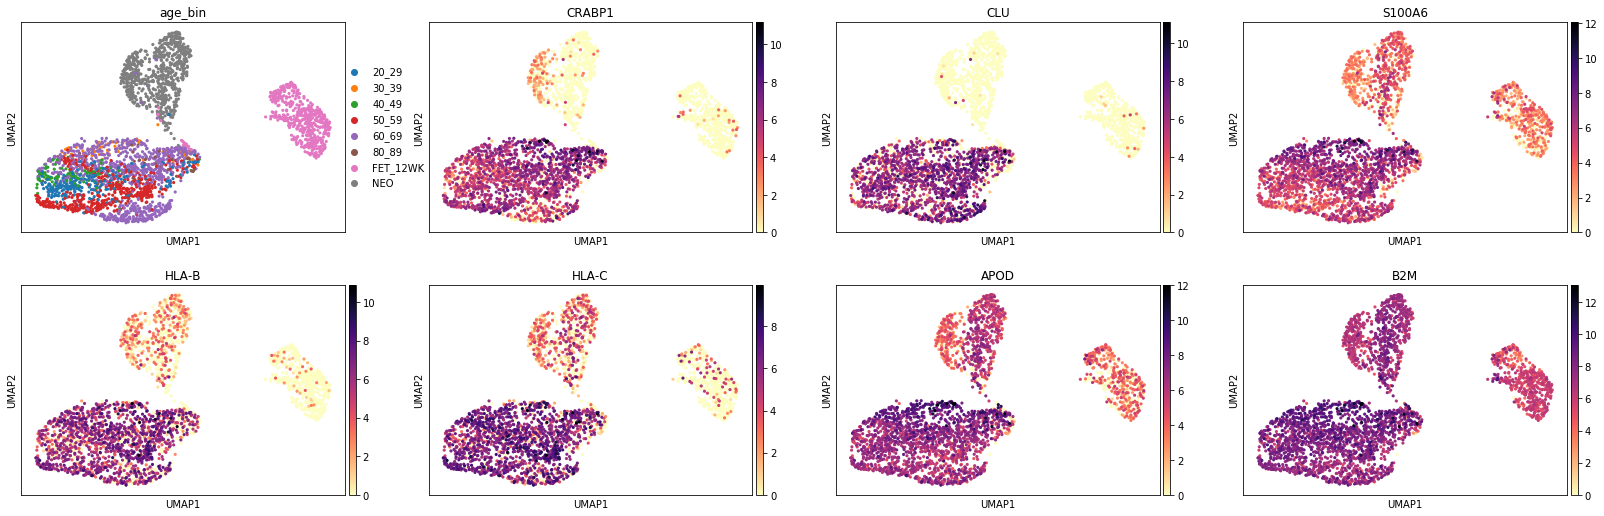

Canonical MEL genes


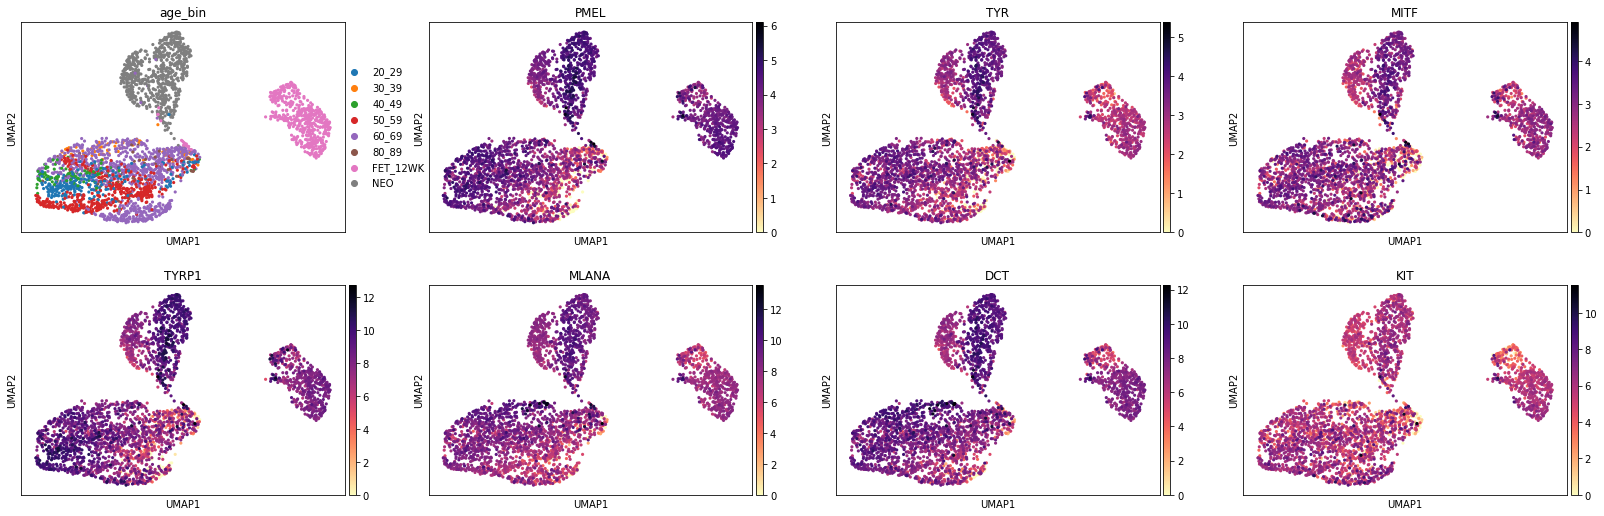

In [13]:
ref = 'age'
corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = pearsonr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'R':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df['R2'] = out_df['R']**2 
out_df = out_df.sort_values('R2', ascending=False)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
print(out_df.head(20))

plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('R','pval'))
          +scale_y_log10()
          +labs(x='Pearsons R', y='p-value'))

# Top negatively correlated genes
print('Top negatively correlated genes')
sc.pl.umap(adata_subset2, color=['age_bin','SERPINF1','CCND1','MYC','IGFBP3','MAL','S100B','QPRT'], cmap='magma_r')

# Top positively correlated genes
print('Top positively correlated genes')
sc.pl.umap(adata_subset2, color=['age_bin','CRABP1','CLU','S100A6','HLA-B','HLA-C','APOD','B2M'], cmap='magma_r')

# Canonical MEL genes
print('Canonical MEL genes')
sc.pl.umap(adata_subset2, color=['age_bin','PMEL','TYR','MITF','TYRP1','MLANA','DCT','KIT'], cmap='magma_r')

# DEV

In [10]:
# outrigger splice variation analysis
#### MUST RUN JUPYTER INSIDE CONDA ENV ####

# pull s3 file system structure
s3dir_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190104_czbiohubseqbot.txt', header=None)
s3dir_df.columns = ['paths']

# filter to only paths with counts tables
s3dir_df = s3dir_df[['.homo.SJ.out.tab' in x for x in s3dir_df.paths]]

# filter to only counts tables that match cell cohort
matched_path = [s3dir_df[[sub in x for x in s3dir_df.paths]].paths.values.tolist()[-1] for sub in adata_subset2.obs.index]

# push paths to s3
# df=pd.DataFrame({'path':matched_path})
# df.to_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/DL201890110_subset2_paths.csv')
# ! aws s3 cp '/home/ubuntu/data/DL20181011_melanocyte_test_data/DL201890110_subset2_paths.csv' 's3://daniel.le-work/MEL_project/'

In [103]:
# determine what additional patient samples to prioritize
# adata_subset2.obs.groupby(['age_bin','race']).count()
(adata_subset2
 .obs
 .loc[:,['age_bin','color','patient']]
 .groupby(['age_bin','color'])
 .nunique())

age_bin  color  patient
age_bin  color                         
20_29    M            1      1        1
30_39    M            1      1        1
40_49    M            1      1        1
50_59    L            1      1        1
         LM           1      1        2
60_69    L            1      1        2
         LM           1      1        1
80_89    LM           1      1        1
FET_12WK nan          1      1        1
NEO      LM           1      1        2

key = class_1, value = MEL, matched = 3331
key = class_2, value = in, matched = 3015
key = age_bin, value = 20_29, matched = 326
key = age_bin, value = 30_39, matched = 126
key = age_bin, value = 40_49, matched = 171
key = age_bin, value = 50_59, matched = 703
key = age_bin, value = 60_69, matched = 1226
key = age_bin, value = 80_89, matched = 106
	Cells: 1772, Genes: 23195
Process expression data...
	Initial:
	Cells: 1772, Genes: 23195
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13411
	Result:
	Cells: 1772, Genes: 9784
Principle component analysis...


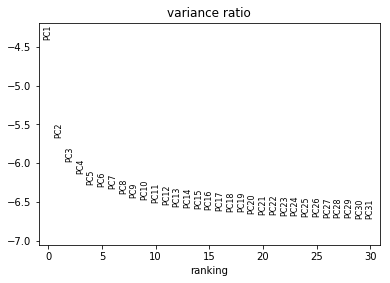

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


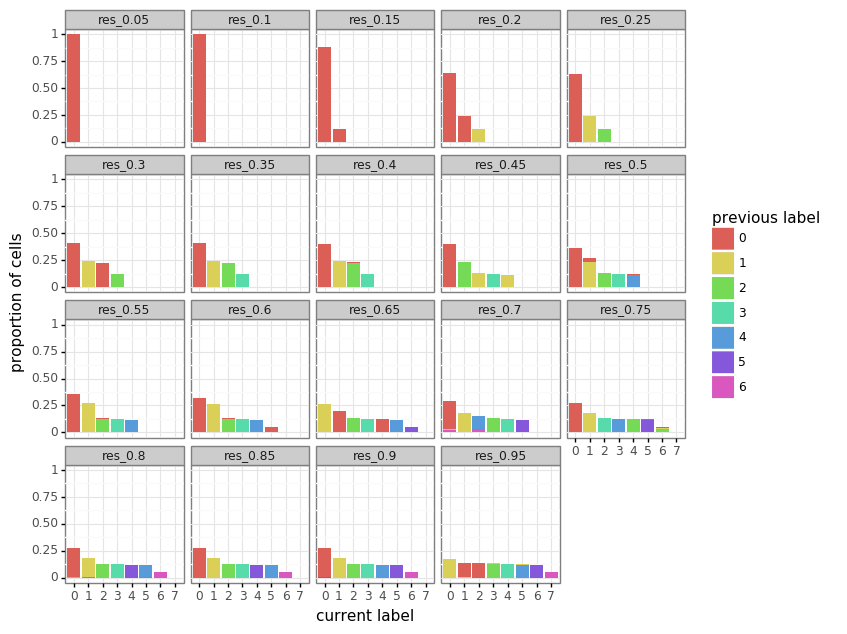

<ggplot: (-9223363283334714087)>


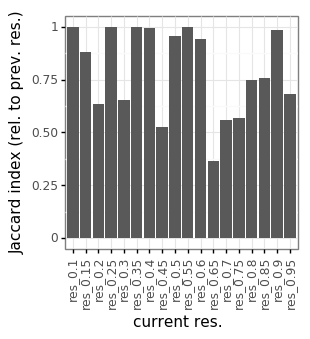

<ggplot: (8753518763198)>
resolution(res): 0.2


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_2' as categorical


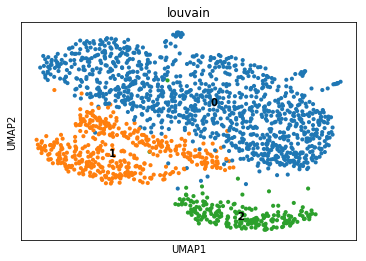

          gene         R           pval        R2
7275     ROPN1 -0.516805  1.364201e-121  0.267088
6876     PTGDS -0.396378   9.616964e-68  0.157116
7546  SERPINF1 -0.363461   1.819094e-56  0.132104
8309     SYNE2 -0.351426   1.163304e-52  0.123500
2392       EZR  0.340268   2.813181e-49  0.115782
9021     TYRP1 -0.308664   2.013781e-40  0.095273
5522      MT2A  0.296549   2.650915e-37  0.087941
6557      PMEL -0.282824   6.029544e-34  0.079989
5617     MYO5A -0.275036   4.009310e-32  0.075645
7308     RPS18  0.262312   2.856362e-29  0.068807
5517      MT1E  0.260682   6.457180e-29  0.067955
7110    RETSAT -0.260521   6.999043e-29  0.067871
1804  CYB561A3 -0.254432   1.398996e-27  0.064736
6890       PTN -0.245680   9.021783e-26  0.060359
1901     DDIT4  0.243990   1.979853e-25  0.059531
7310     RPS27  0.242343   4.232132e-25  0.058730
4952    MALAT1  0.240709   8.949367e-25  0.057941
7125      RGCC  0.240303   1.076698e-24  0.057746
7006     RAMP1  0.236728   5.413829e-24  0.056040


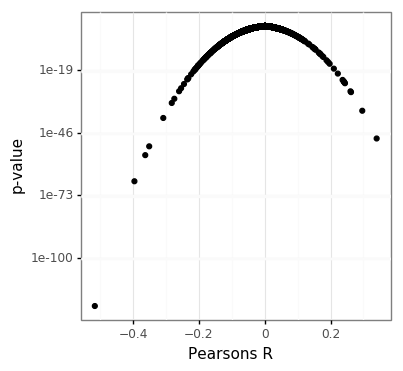

<ggplot: (8753521843113)>


In [15]:
# look for age correlation in adt MELs

run = False
if run is True:

    feature_dict = {'class_1':['MEL'],
                    'class_2':['in'],
                    'age_bin':['20_29','30_39','40_49','50_59','60_69','80_89']}
    adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
    adata_subset3 = process_adata(adata_subset3)
    pca_adata(adata_subset3, num_pcs=30)
    umap_adata(adata_subset3, res=0.2)

    # correlation to age
    input_adata=adata_subset3

    ref = 'age'
    corr_age = pd.DataFrame(input_adata.X)
    corr_age.columns = input_adata.var_names
    corr_age[ref] = input_adata.obs[ref].tolist()

    df = corr_age.dropna()._get_numeric_data()
    r_list = []
    p_list = []
    gene_list = []
    for col in df.columns.tolist():
        r, pval = pearsonr(df[ref], df[col])
        r_list.append(r)
        p_list.append(pval)
        gene_list.append(col)
    out_df = pd.DataFrame({'gene':gene_list,
                           'R':r_list, 
                           'pval':p_list})
    out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
    out_df['R2'] = out_df['R']**2 
    out_df = out_df.sort_values('R2', ascending=False)
    out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
    print(out_df.head(20))

    plotnine.options.figure_size=(4,4)
    print(ggplot(out_df)
              +theme_bw()
              +geom_point(aes('R','pval'))
              +scale_y_log10()
              +labs(x='Pearsons R', y='p-value'))

### Conclusion: weak correlation between age and expression in adt MEL

In [ ]:
# find coherent gene sets by clustering gene-cell counts table
## try this: https://www.biorxiv.org/content/biorxiv/early/2018/07/11/367003.full.pdf

# output necessary input cell/gene counts table
## format: ENSEMBL_ID  GENE_NAME  UMICOUNT_CELL0  UMICOUNT_CELL1 ...
## no header
## only MEL cells and raw counts
dense_mels = pd.DataFrame(np.exp(adata_subset2.raw.X.todense().T).astype(int)-1)
dense_mels = pd.concat([pd.DataFrame({'gene':adata_subset2.raw.var_names}),dense_mels],axis=1)
 
(dense_mels
 .to_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190102_schpf_input.txt', 
        header=False,
        sep=' '))


In [ ]:
# read in gene scoeres from scHPF
input_param = '21x5'

gene_score = pd.read_csv(f'/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf_report_{input_param}.gene_score.txt',
           header=None,
           delimiter='\t')

gene_df = pd.concat([(pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf.genes.txt',
           header=None,
           delimiter='\t')
            .iloc[:,1]),
           gene_score], axis=1)
gene_df.columns = ['gene'] + [f'factor_{x}' for x in range(gene_score.shape[1])]

cell_scores = pd.read_csv(f'/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf_report_{input_param}.cell_score.txt',
               header=None,
               delimiter='\t')
cell_scores.columns = [f'cell_score_{x}' for x in range(cell_scores.shape[1])]

for col in cell_scores.columns:
    adata_subset2.obs[col] = cell_scores.loc[:,col].values

sc.pl.umap(adata_subset2, color=['age','age_bin']+cell_scores.columns.tolist(), cmap='magma_r')

In [ ]:
geneset = 'gene_rank_4'

ranked_genes = pd.read_csv(f'/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf_report_{input_param}.ranked_genes.txt',
           header=None,
           delimiter='\t')

ranked_genes.columns = [f'gene_rank_{x}' for x in range(ranked_genes.shape[1])]

genelist = ranked_genes.loc[:,geneset].values.tolist()[-30:]
sc.pl.umap(adata_subset2, color=genelist, cmap='magma_r')
out = symbol2field(genelist)
[print(x['query'],'\n',x['summary']) if ('summary' in x.keys()) else print(x['query'],'\n','N/A') for x in out]


In [ ]:
# Aging-associated gene set
ageGenes_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/age_related_genes.txt', delimiter= '\t', header=None)
ageGenes_df.columns = ['gene']

input_adata=adata_subset1
groupby='age_bin'

# age-related genes
genelist = [x.strip() for x in ageGenes_df['gene'].values.tolist() if x.strip() in input_adata.var_names.tolist()]+['CDKN2A']

# random genes
# genelist = np.random.choice(input_adata.var_names.tolist(), 100 ,replace=False).tolist()

cats, casted_df = prepare_dataframe(input_adata, 
                                     genelist, 
                                     groupby='age_bin')
casted_df = casted_df.reset_index()
casted_df['age'] = input_adata.obs[['age','age_bin']].reset_index()['age']
corr_df = casted_df.corr()

cats, casted_df = prepare_dataframe(input_adata, 
                                     genelist, 
                                     groupby=groupby)

df = pd.merge(pd.melt(casted_df.astype(bool)
        .reset_index()
        .groupby(groupby)
        .sum(axis=0)
        .reset_index(), id_vars='age_bin').rename(columns={'value':'nonzero'}),
        pd.melt(casted_df
                .reset_index()
                .groupby(groupby)
                .count()
                .reset_index(), id_vars='age_bin').rename(columns={'value':'total'}),
         'left',
         ['age_bin','variable'])
df['nonzero_exp'] = df['nonzero'] / df['total']
df[f'{groupby}_cat'] = df[groupby].astype(str).astype(CategoricalDtype(['FET_12WK',
                                                                         'NEO',
                                                                         '20_29',
                                                                         '30_39',
                                                                         '40_49',
                                                                         '50_59',
                                                                         '60_69',
                                                                         '80_89',], ordered=True))

df = pd.merge(df,
              corr_df.reset_index().loc[:,['index','age']].rename(columns={'index':'variable','age':'R2'}),
                'left','variable')

plotnine.options.figure_size=(8,8)
print(ggplot(df) 
      +theme_bw()
      +theme(axis_text_x=element_text(angle=90))
      +geom_tile(aes('variable',f'{groupby}_cat',fill='nonzero_exp')))

print(ggplot(df.loc[:,['variable','R2']].drop_duplicates()) 
      +theme_bw()
      +theme(axis_text_x=element_text(angle=90))
      +geom_bar(aes('variable','R2',fill='R2'), stat='identity')
      +scale_fill_gradient2())

print('abs median R2 = {}'.format(np.median(abs(df.loc[:,['variable','R2']].drop_duplicates()['R2']))))

# pull in all ercc data

In [ ]:
run = False
if run is True:

    # pull s3 file system structure
    s3dir_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190104_czbiohubseqbot.txt', header=None)
    s3dir_df.columns = ['paths']

    # filter to only paths with counts tables
    s3dir_df = s3dir_df[['homo.htseq-count.txt' in x for x in s3dir_df.paths]]

    # filter to only counts tables that match cell cohort
    matched_path = [s3dir_df[[sub in x for x in s3dir_df.paths]].paths.values.tolist()[-1] for sub in pre_adata.columns]

    # pull and merge individual counts tables
    master_df = pd.read_csv(matched_path[0], header=None, delimiter='\t', usecols=[0])
    master_df.columns = ['gene']
    for path,name in tqdm(zip(matched_path, pre_adata.columns)):
        pulled_col = pd.read_csv(path, header=None, delimiter='\t', usecols=[1])
        pulled_col.columns = [name]
        master_df = pd.concat([master_df, pulled_col], axis=1)

    # remove metadata    
    master_df = master_df[["__" not in x for x in master_df.gene]]

    # write to disk
    master_df.to_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190104_counts_wERCC.txt')

    # push to s3
    ! aws s3 cp /home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190104_counts_wERCC.txt s3://daniel.le-work/MEL_project/
